In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
!nvidia-smi

Mon Apr 24 19:14:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |    373MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
!pip install tensorflow==2.2.0

In [ ]:
tf.__version__

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img

import matplotlib.pyplot as plt

In [ ]:
# Resize images
img_height = 90
img_width = 120
image_size = [img_height, img_width, 3] # height, width, depth

# Output classes
predict_class_size = 2

# batch size
bs = 32

data_dir = '/content/drive/My Drive/colab/data'

In [ ]:
model_dict = {VGG19:"vgg19", InceptionV3:"inceptionv3", ResNet152V2:"resnet152v2"}

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, # normalize pixel values
    #rotation_range=20, # randomly rotate images up to 20 degrees
    width_shift_range=0.2, # randomly shift images horizontally by up to 20% of image width
    height_shift_range=0.2, # randomly shift images vertically by up to 20% of image height
    horizontal_flip=True, # randomly flip images horizontally
    zoom_range=0.2, # randomly zoom into images up to 20%
    validation_split=0.2 # use 20% of the data for validation
)

train_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode='binary', # if you have more than 2 classes, use 'categorical'
    shuffle=True, # shuffle the training data
    subset='training' # use the training subset
)

val_ds = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode='binary', # if you have more than 2 classes, use 'categorical'
    shuffle=False, # don't shuffle the validation data
    subset='validation' # use the validation subset
)


Found 4689 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [ ]:
def plot_loss_acc(model_history, model_name):
    
    ## Plot loss
    plt.plot(model_history.history['loss'], label='train loss')
    plt.plot(model_history.history['val_loss'], label='test loss')
    plt.legend()
    plt.savefig('/content/drive/My Drive/colab/models/loss_{}'.format(model_name))
    plt.clf()

    ## Plot Accuracy
    plt.plot(model_history.history['accuracy'], label='train accuracy')
    plt.plot(model_history.history['val_accuracy'], label='test accuracy')
    plt.legend()
    plt.savefig('/content/drive/My Drive/colab/models/accuracy_{}'.format(model_name))
    plt.clf()

# ResNet152V2, VGG16, **InceptionV3**

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def train_model(pre_trained_model):
    
    # Intialize pre trained model (ResNet152V2, VGG19, InceptionV3) with imagenet weights
    pre_trained_net = pre_trained_model(input_shape=image_size, weights='imagenet', include_top=False)

    # Unfreeze some of the layers for fine-tuning
    for layer in pre_trained_net.layers[-10:]:
        layer.trainable = True

    # Add new layers on top of the pre-trained model
    model = tf.keras.models.Sequential()

    model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(90,120,3)))
    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(tf.keras.layers.Dropout(rate=0.3))

    model.add(Conv2D(64, (3,3), 1, activation='relu'))
    model.add(Conv2D(64, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(tf.keras.layers.Dropout(rate=0.3))

    model.add(Conv2D(128, (3,3), 1, activation='relu'))
    model.add(Conv2D(128, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(tf.keras.layers.Dropout(rate=0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(Dense(1, activation='sigmoid'))

    # Set cost and optimization functions for model
    model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

    
    # Image Data Augmentation using keras ImageDataGenerator
    # train data generator
#     train_aug = ImageDataGenerator(rescale=1/255, 
#                                    rotation_range=10, 
# #                                    width_shift_range=0.2, # horizontal shift
# #                                    height_shift_range=0.2, # vertical shift
# #                                    horizontal_flip=True, 
# #                                    vertical_flip=True, 
#                                    zoom_range=0.2, # ~ [1-0.2, 1+0.2]
#                                    brightness_range=[0.5,1.5]) # <1 darkens img, >1 brightens img
#     # test data generator
#     test_aug = ImageDataGenerator(rescale=1/255)

#     # Create train/test set
#     train_set = train_aug.flow_from_directory(train_dir, 
#                                               target_size=(img_height,img_width), 
#                                               batch_size=bs, 
#                                               class_mode='binary')

#     test_set = test_aug.flow_from_directory(test_dir, 
#                                             target_size=(img_height,img_width), 
#                                             batch_size=bs, 
#                                             class_mode='binary')

    # fit the model
    hist = model.fit( train_ds, 
                      epochs=50,
                      steps_per_epoch=len(train_ds),
                      validation_data=val_ds,
                      validation_steps=len(val_ds)
                     )
    
    # model name
    model_name = model_dict[pre_trained_model]
    
    # Save model loss/accuracy plots
    plot_loss_acc(hist,model_name)
    
    # Save model
    model.save('/content/drive/My Drive/colab/models/model_{}.h5'.format(model_name))
    
    print("model {} trained and saved".format(model_name))

In [ ]:
for each_model in list(model_dict.keys()):
    train_model(each_model)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/50
147/147 [==============================] - 765s 5s/step - loss: 0.7056 - accuracy: 0.5255 - val_loss: 0.6703 - val_accuracy: 0.5947
Epoch 2/50
147/147 [==============================] - 88s 594ms/step - loss: 0.6847 - accuracy: 0.5545 - val_loss: 0.6714 - val_accuracy: 0.6271
Epoch 3/50
147/147 [==============================] - 89s 609ms/step - loss: 0.6669 - accuracy: 0.5935 - val_loss: 0.6445 - val_accuracy: 0.6357
Epoch 4/50
147/147 [==============================] - 90s 610ms/step - loss: 0.6379 - accuracy: 0.6251 - val_loss: 0.6400 - val_accuracy: 0.6476
Epoch 5/50
147/147 [==============================] - 88s 602ms/step - loss: 0.6081 - accuracy: 0.6618 - val_loss: 0.5824 - val_accuracy: 0.7167
Epoch 6/50
147/147 [==============================] - 90s 608ms/step - loss: 0.5637 - accuracy: 0.6987 - val_loss: 0.5874 - val_accuracy: 0.6809
Epoch 7/50
147/147 [==============================] - 87s 589ms/ste

KeyboardInterrupt: ignored

<Figure size 640x480 with 0 Axes>

# ***Hybrid Model 1***

# 1

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Multiply, Concatenate, Input, Dropout, ZeroPadding2D, Flatten
from tensorflow.keras import backend as K
from keras.layers import concatenate

# datasets_bin = [count_class_samples( RAW_TRAIN_DATASET, NUMBER_CLASSES)]
# dataset["mix_train"] = RAW_TRAIN_DATASET

# Method to define all the algorithms used for the architecture
def define_all_models():
    all_models = list()

    inputs = Input(batch_shape=(None, None, None, 3))

    base_model1 = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=(90, 120, 3),
        input_tensor=inputs
    )
    base_model1_out = GlobalAveragePooling2D()(base_model1.output)
    all_models.append((base_model1, base_model1_out))

    base_model2 = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet', 
        include_top=False, 
        input_shape=(90, 120, 3),
        input_tensor=inputs
    )
    base_model2_out = GlobalAveragePooling2D()(base_model2.output)
    all_models.append((base_model2, base_model2_out))
    return all_models, inputs

# Create the final architecture
def model_define():

    models, inputs = define_all_models()

    for i in range(len(models)):
      model = models[i][0]
      for layer in model.layers:
        layer._name = 'ensemble_' + layer.name + str('_model_') + str(i + 1)
    
    print(models[0][1].shape)
    print(models[1][1].shape)

    out1 = models[0][1]
    out1 = Dense(1024, activation='relu')(out1) # added dense layer 
    out1 = Dropout(0.3)(out1)  # to prevent overfitting
    out2 = models[1][1]
    out2 = Dense(1024, activation='relu')(out2) # added dense layer 
    out2 = Dropout(0.3)(out2)  # to prevent overfitting
    
    outputs = concatenate([out1, out2])

    outputs = Dropout(0.3)(outputs)
    outputs = Dropout(0.3)(outputs)
    outputs = Dense(512, activation='relu')(outputs) # newly added dense layer
    outputs = Flatten()(outputs)
    outputs = Dropout(0.3)(outputs)  # to prevent overfitting
    outputs = Dense(512, activation='relu')(outputs)
    outputs = Dense(1, activation='sigmoid')(outputs) # Sigmoid Activation layer for classification
    

    model = Model(inputs=inputs, outputs=outputs) 

    # plot_model(model, show_shapes=True, to_file='ensemble_models.png')
    
    model.compile(
        optimizer=Adam(learning_rate=0.001), # Good with sparse data
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    
    model.summary()
    
    return model

# 2

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPool2D, Multiply, Concatenate, Input, Dropout, ZeroPadding2D, Flatten, LeakyReLU, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from keras.layers import concatenate

def define_all_models():
    all_models = list()

    inputs = Input(batch_shape=(None, None, None, 3))

    base_model1 = tf.keras.applications.inception_v3.InceptionV3(
        weights='imagenet', 
        include_top=False, 
        input_shape=(90, 120, 3),
        input_tensor=inputs
    )

    all_models.append(base_model1)

    base_model2 = tf.keras.applications.resnet50.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(90, 120, 3),
        input_tensor=inputs
    )

    all_models.append(base_model2)
    return all_models, inputs

# Create the final architecture
def model_define():
    models, inputs = define_all_models()

    for i in range(len(models)):
      model = models[i]
      for layer in model.layers:
        layer.trainable = False
        
    
    print(models[0].output.shape)
    print(models[1].output.shape)

    out1 = models[0].output
    out1 = ZeroPadding2D(((0,2), (0,2)))(out1) # Zero-padding layer for 2D input 
    
    outputs = concatenate([out1, models[1].output])

    # used for global average pooling operation for spatial data.
    z = BatchNormalization()(outputs)
    z = GlobalAveragePooling2D()(z)
    z = Dropout(0.2)(z)
    z = LeakyReLU(alpha=0.1)(z)  # to prevent overfitting
    z = Multiply()([outputs, z])
    z = GlobalAveragePooling2D()(z)
    z = Flatten()(z)
    z = Dropout(0.3)(z)
    z = Dense(1024, activation='relu')(z)
    z = Dense(256, activation='relu')(z)
    z = Dense(1, activation="sigmoid")(z) # "sigmoid" Activation layer for classification

    model = Model(inputs=inputs, outputs=z) 

    model.compile(
        optimizer="adam",
        loss='binary_crossentropy',
        metrics=["accuracy"]
    )
    
    # model.summary()
    
    return model

In [ ]:
model = model_define()

(None, None, None, 2048)
(None, None, None, 2048)


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

In [ ]:
steps_per_epoch = len(train_ds) // bs
print(len(train_ds))
print(steps_per_epoch)

147
4


In [ ]:
model_train = model.fit(
        train_ds,
        steps_per_epoch = len(train_ds),
        epochs = 30,
        validation_data = val_ds,
        validation_steps = len(val_ds),
        validation_freq = 1,
)

Epoch 1/30
147/147 [==============================] - 41s 219ms/step - loss: 0.6012 - accuracy: 0.6833 - val_loss: 0.6395 - val_accuracy: 0.6681
Epoch 2/30
147/147 [==============================] - 30s 203ms/step - loss: 0.5526 - accuracy: 0.7091 - val_loss: 0.5211 - val_accuracy: 0.7295
Epoch 3/30
147/147 [==============================] - 30s 204ms/step - loss: 0.5359 - accuracy: 0.7260 - val_loss: 0.5029 - val_accuracy: 0.7568
Epoch 4/30
147/147 [==============================] - 30s 203ms/step - loss: 0.5145 - accuracy: 0.7426 - val_loss: 0.4789 - val_accuracy: 0.7713
Epoch 5/30
147/147 [==============================] - 35s 236ms/step - loss: 0.5094 - accuracy: 0.7424 - val_loss: 0.4780 - val_accuracy: 0.7747
Epoch 6/30
147/147 [==============================] - 30s 204ms/step - loss: 0.5040 - accuracy: 0.7498 - val_loss: 0.4782 - val_accuracy: 0.7799
Epoch 7/30
147/147 [==============================] - 30s 203ms/step - loss: 0.4925 - accuracy: 0.7526 - val_loss: 0.4676 - val_ac

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(30)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

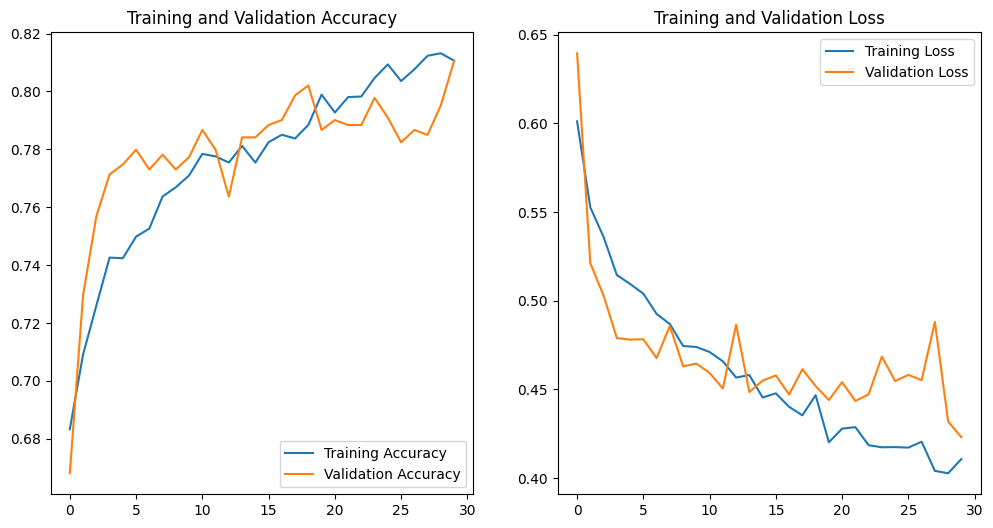

In [ ]:
plot_history(model_train)

In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# make predictions on the test dataset
y_pred = model.predict(val_ds)

# convert predicted probabilities to binary labels
y_pred = [1 if p>=0.5 else 0 for p in y_pred]

# get true labels of the test dataset
y_true = val_ds.classes

# calculate precision, recall, and binary accuracy
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print('Precision:', precision)
print('Recall:', recall)
print('Binary accuracy:', accuracy)

37/37 [==============================] - 6s 152ms/step
Precision: 0.7908496732026143
Recall: 0.825938566552901
Binary accuracy: 0.8037542662116041


37/37 [==============================] - 6s 149ms/step


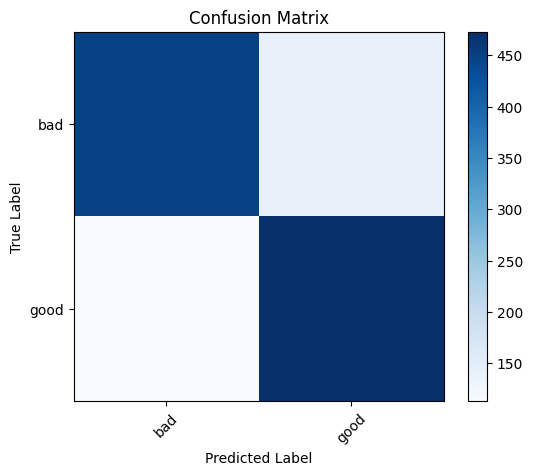

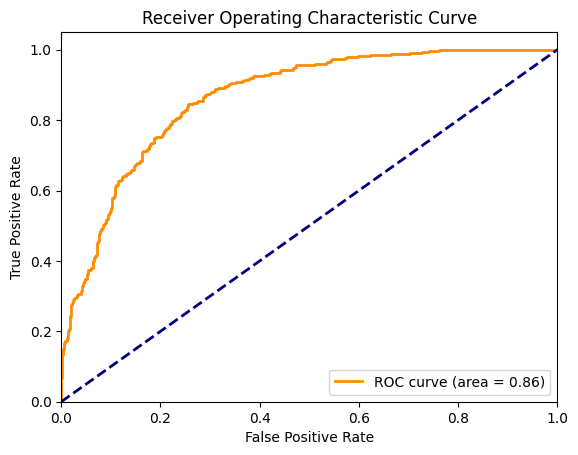

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# define the classes variable
classes = train_ds.class_indices.keys()

# get predictions on validation set
y_pred_proba = model.predict(val_ds)
y_pred = np.round(y_pred_proba).flatten()
y_true = val_ds.labels

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# get AUC/ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

# plot AUC/ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

plt.show()


In [ ]:
# Save model
model.save('/content/drive/My Drive/colab/models/model_{}.h5'.format("hybrid_model_mark04"))

In [ ]:
# Save model loss/accuracy plots
plot_loss_acc(model_train,"hybrid_model_mark01")

<Figure size 640x480 with 0 Axes>

In [ ]:
import tensorflow as tf
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

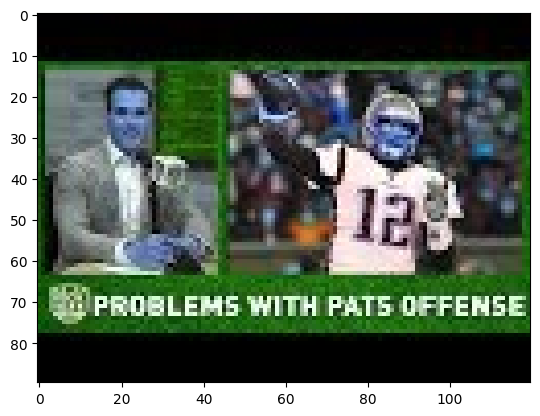

In [ ]:
img = cv2.imread('/content/sample_data/sample_22.jpg')
plt.imshow(img)
plt.show()

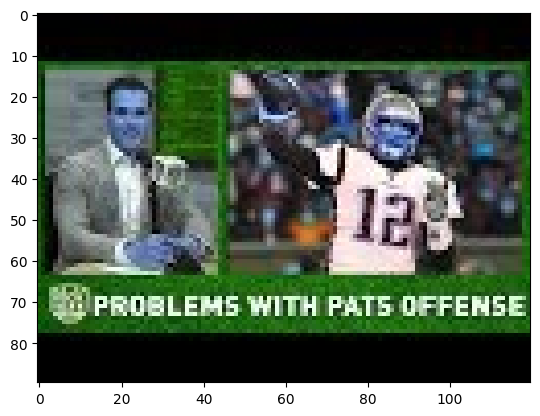

In [ ]:
resize = tf.image.resize(img, (90,120))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
hybrid_model = tf.keras.models.load_model('/content/drive/MyDrive/colab/models/model_hybrid_model_mark02.h5')


In [ ]:
model.predict(np.expand_dims(resize/255, 0))

NameError: ignored

In [ ]:
hybrid_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 13s 13s/step


array([[0.05868922]], dtype=float32)

# Hybrid Model **2**

In [ ]:
X_train, y_train = train_ds.next()
X_test, y_test = val_ds.next()

In [ ]:
def load_all_models():
    all_models = []
    model_names = ['model_vgg19.h5', 'model_resnet152v2.h5', 'model_inceptionv3.h5']
    for model_name in model_names:
        filename = os.path.join('/content/drive/My Drive/colab/models', model_name)
        model = tf.keras.models.load_model(filename)
        all_models.append(model)
        print('loaded:', filename)
    return all_models
models = load_all_models()
for i, model in enumerate(models):
    for layer in model.layers:
        layer.trainable = False

loaded: /content/drive/My Drive/colab/models/model_vgg19.h5
loaded: /content/drive/My Drive/colab/models/model_resnet152v2.h5
loaded: /content/drive/My Drive/colab/models/model_inceptionv3.h5


In [ ]:
ensemble_visible = [model.input for model in models]
ensemble_outputs = [model.output for model in models]

merge = tf.keras.layers.concatenate(ensemble_outputs)

merge = tf.keras.layers.Dropout(.3)(merge)
merge = tf.keras.layers.Dropout(.3)(merge)
merge = tf.keras.layers.Dense(512, activation='relu')(merge)
merge = tf.keras.layers.Dropout(.2)(merge)
merge = tf.keras.layers.Dense(1024, activation='relu')(merge)
output = tf.keras.layers.Dense(1, activation='sigmoid')(merge)

model = tf.keras.models.Model(inputs=ensemble_visible, outputs=output)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [ ]:
X = [X_train for _ in range(len(model.input))]
X_1 = [X_test for _ in range(len(model.input))]

In [ ]:
epochs = 20
history = model.fit(X, y_train,
                    batch_size=bs,
                    steps_per_epoch=len(train_ds),
                    epochs=epochs,
                    validation_data=(X_1, y_test),
                    validation_steps=len(val_ds)
                    )

Epoch 1/20
 19/147 [==>...........................] - ETA: 1s - loss: 0.5891 - accuracy: 0.7516

147/147 [==============================] - 0s 3ms/step - loss: 0.5899 - accuracy: 0.7531 - val_loss: 0.5043 - val_accuracy: 0.9062
